In [2]:
'''
대중교통 데이터 내려받기

지하철 시간대별 데이터 분석 (반드시 pandas)

사용자가 특정 호선을 입력하면 다음 내용을 시간대별 시각화
1) 출퇴근 시간 유동인구가 많은 역 상위 3개 승/하차 인원시각화
2) 입력 받은 해당 호선 출퇴근 시간 유동인구가 가장 많은 역과 시간대별 승/하차 비율이 유사한 역 5개 시각화
3) 입력 받은 해당 호선 출퇴근 시간 유동인구와 출퇴근 시간 외의 유동인구의 승/하차 비율 차이가 가장 큰 지역과, 크지 않은 지역 각3개 
*출근 시간: 07:00:00~09:59:59
*퇴근 시간: 17:00:00~19:59:59
*유동인구: 승차 + 하차 인원 
*3개의 프로그램을 모두 1개의 ipynb에 따로 구현 
'''


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

pd.options.display.float_format = '{:.5f}'.format

# 문제 1번

특정 호선을 입력: 4호선


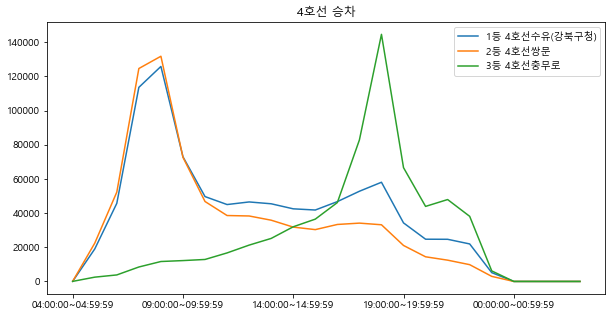

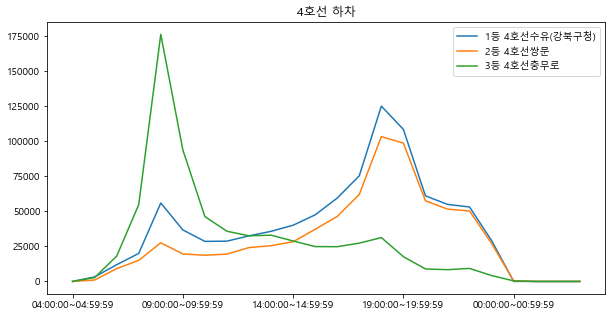

In [3]:
# 홀수 열 (listOdd)만 가져와서 승차 데이터 추출 -> df1 
# 짝수 열 (listEven)만 가져와서 하차 데이터 추출 -> df2
listEven = [0,1]
listOdd = [0]
for i in range (1, 50) : 
    if i%2==0 : listEven.append(i)
    else : listOdd.append(i)

df1 = pd.read_csv('subway_time.csv', header=None, encoding='utf-8', index_col=0, usecols=listEven)
df2 = pd.read_csv('subway_time.csv', header=None, encoding='utf-8', index_col=0, usecols=listOdd)

df1 = df1.rename(columns=df1.iloc[0])
df1 = df1.drop(df1.index[:2])
df2.columns = df1.columns
df2 = df2.drop(df2.index[:2])

# ndex -> index + 지하철역 명 으로 수정 
df1.index = df1.index + df1["지하철역"]
del df1["지하철역"]
df2.index = df2.index + df2["지하철역"]
del df2["지하철역"]

# 문자열을 제외한 모든 데이터를 int형으로 바꿔주어야 계산할 수 있음 
df1 = df1.apply(pd.to_numeric, errors = 'ignore')
df2 = df2.apply(pd.to_numeric, errors = 'ignore')



# 특정 호선 입력받고 호선에 맞는 데이터로 가공 
# a -> 특정 호선 내 승차 데이터 
# b -> 특정 호선 내 하차 데이터 
name = input("특정 호선을 입력: ")

a = df1[df1.index.str.match(name)].copy()
b = df2[df2.index.str.match(name)].copy()

# Total -> 열을 새롭게 추가해 각 역마다 승차/하차 데이터 값을 더해줌 
a["Total"] = a.iloc[:,3:6].sum(axis=1)
a["Total"] += a.iloc[:,13:16].sum(axis=1)

b["Total"] = b.iloc[:,3:6].sum(axis=1)
b["Total"] += b.iloc[:,13:16].sum(axis=1)

# c -> 승차 Total + 하차 Total 을 통해 상위 3개의 역을 선정 => 즉, c는 최종 3개의 역 이름만 가지게 됨  
c = a["Total"] + b["Total"]
c = c.sort_values(ascending=False)
c = c.head(3).index



# 결과 출력 
plt.rc("font", family="Malgun Gothic")
plt.rcParams['figure.figsize'] = [10,5]
legend = ["1등 "+c[0], "2등 "+c[1], "3등 "+c[2]]

df1.loc[c].T.plot(title = name+ " 승차")
plt.legend(legend)
df2.loc[c].T.plot(title = name+ " 하차")
plt.legend(legend)
plt.show()


# 문제 2번

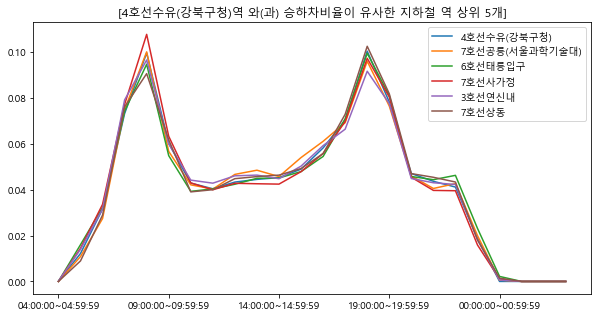

In [5]:
# 입력 받은 호선의 출퇴근 시간에 유동인구가 가장 많은 역의 index
id = c[0]

# 시간대별 승차 데이터 + 하차 데이터 -> df3 
df3 = df1.copy() + df2.copy()

# 행의 총합 데이터를 각 시간대별 데이터에 나눠줌 -> 비율 데이터가 저장됨 -> df4
# x -> 각 비율데이터로부터 "유동인구가 가장 많은 역의 비율"을 빼주고 제곱 (음수값이 있으므로)
# y -> 제곱 비율을 더한 값들을 오름차순을 정렬, 상위 6개의 데이터를 추출 
# 가장 최상위 데이터는 자동으로 가장 유동인구가 많은 역이 됨 
df4 = df3.copy()
df4 = df4.div(df4.sum(axis=1), axis=0)
x = df4.sub(df4.loc[id], axis=1)
x = np.power(x,2)
y = x.sum(axis=1).sort_values().head(6)



# 결과 출력 
plt.rcParams['figure.figsize'] = [10,5]
df4.loc[y.index].T.plot(title= "["+id+"역 와(과) 승하차비율이 유사한 지하철 역 상위 5개]")
plt.show()


# 문제 3번 

In [ ]:
# 특정 호선의 승차 + 하차 비율 데이터 -> df4
df4 = df4[df4.index.str.match(name)].copy()

# Total -> 출퇴근 시간 데이터 비율의 합  
# notTotal -> 출퇴근 시간 이외의 데이터 비율의 합
# dif -> 출퇴근 시간 비율과 이외 시간의 비율 차의 제곱 
x = df4.copy()
x["Total"] = x.iloc[:, 3:6].sum(axis=1) + x.iloc[:,13:16].sum(axis=1)
x["notTotal"] = 1.0-x["Total"]
x["dif"] = np.power(x["Total"] - x["notTotal"],2)

# dif, 비율 차의 제곱으로부터 나열 후 상위 3개, 하위 3개를 각각 추출 
# y -> 차이가 큰 index 
# z -> 차이가 작은 index 
y = x.sort_values(by="dif", ascending=False).head(3)
z = x.sort_values(by="dif", ascending=False).tail(3)  



# 결과 출력 
plt.rcParams['figure.figsize'] = [10,5]
df4.loc[y.index].T.plot(title=name+" 승/하차 비율 차이 큰 역 3개")
df4.loc[z.index].T.plot(title=name+" 승/하차 비율 차이 작은 역 3개")
plt.show()